In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()

from scipy.stats import multivariate_normal

# Creation of the inital data

In [3]:
x, y = np.mgrid[0:100:100j, 0:100:100j]
sigma = 5


def plot_extended_space(z, label=None):
    """
    Plot using imshow in the extended space
    """
    
    plt.figure()
    
    if label:
        plt.title(label)
        
    plt.grid(False)
    plt.imshow(z, aspect='auto', origin='lower')
    plt.colorbar()


def generate_random_ground_truth(num, x):
    """
    Generate a random distribution of points in a compact space
    """
    
    gt_indexes = np.random.randint(0, np.max(x), 2*num)
    gt_indexes = gt_indexes.reshape([num, 2])
    
    return gt_indexes
    

def compact_to_extended(gt_indexes, x):
    """
    Takes the ground truth in the compact space and convert it to
    the extended space for easier comparaison.
    """
    
    x_size = len(x)
    gt = np.zeros([x_size, x_size])
    
    for k in gt_indexes:
        # print(gt[gt_indexes[k], gt_indexes[k+num-1]])
        gt[k[0], k[1]] = 1
        
    return gt
    
      
def plot_ground_truth(gt, x):
    """
    Plot the ground truth.
    """
    
    plt.figure()
    
    # find non empty values
    gt_x = gt[:,0]
    gt_y = gt[:,1]
    
    # plot
    plt.title("Ground Truth (Compact Space)")
    plt.scatter(gt_y, gt_x) # x and y are inverted to match other representations
    
    

def generate_density_map(gt, x, sigma=sigma):
    """
    Generate a 2D density map from the ground truth
    """
    
    dm = np.zeros(x.shape)

    for k in gt:
        dm += gaussian_distribution_2D(x, y, k, sigma)

    return dm
    

def gaussian_distribution_2D(x, y, mu, sigma):
    """
    Create a z map for a (x,y) 2D-grid containing the gaussian distribution centred in mu
    and of variance sigma.
    
    Note: the result is already normalised to have a density of 1 if the entire distribution fit
    in the given space. It might be significantly smaller if the gaussian is over the 
    """
    
    # Need an (N, 2) array of (x, y) pairs.
    xy = np.column_stack([x.flat, y.flat])

    sigma_xy = np.array([sigma, sigma]) # sigma_x = sigma_y
    covariance = np.diag(sigma_xy**2)
    
    z = multivariate_normal.pdf(xy, mean=mu, cov=covariance)
    
    # reshape back to the size of the grid
    z = z.reshape(x.shape)
    
    return z

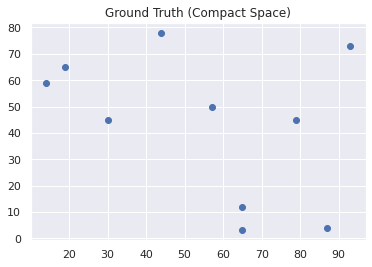

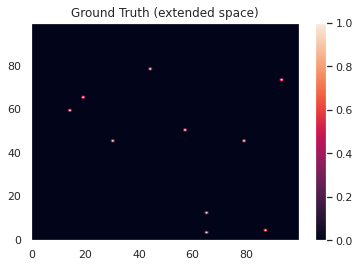

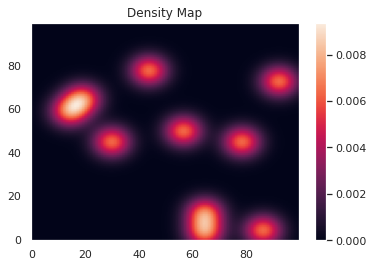

In [8]:
gt = generate_random_ground_truth(10, x)
plot_ground_truth(gt, x)

gt_e = compact_to_extended(gt, x)
plot_extended_space(gt_e, label="Ground Truth (extended space)")

dm = generate_density_map(gt, x)
plot_extended_space(dm, label="Density Map")

# Adversary dectection methods

In [4]:
def detection_voting(density_map, alpha, threshold=0.5):
    """
    Try to detect the position of individuals using the density map.
    Uses a voting methods by looking at the maximum in a square
    of side length alpha.
    
    The end goal is to infer the ground truth from the density map as
    closely as possible.
    """
    
    N = len(density_map)
    vote = np.zeros([N, N]) # creates an empty vote map
    
    # Count the votes
    for x_k in range(N - alpha):
        for y_k in range(N - alpha):
            
            # define the local search space
            square = density_map[x_k:x_k+alpha, y_k:y_k+alpha]
            
            # local coordinate system
            l_x, l_y = np.unravel_index(np.argmax(square, axis=None), square.shape)
            # unravel is necessary to go from the 1D coordinate of the flatten array to the
            # 2D cooridate of the original 2D array. Works in N dimensions.
            
            # global coorinate system
            g_x, g_y = l_x + x_k, l_y + y_k  
            
            vote[g_x, g_y] += 1
            
    # Thresholding
    # vote = np.clip(vote, threshold*alpha**2, np.inf) # because the theoretical maximum is always alpha**2
    for x_k in range(N):
        for y_k in range(N):
            if vote[x_k, y_k] > threshold*alpha**2:
                vote[x_k, y_k] = 1
            else:
                vote[x_k, y_k] = 0
    
    return vote

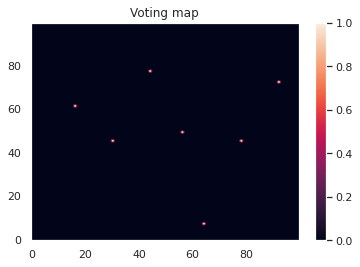

In [42]:
voting_map = detection_voting(dm, 10)
plot_extended_space(voting_map, label="Voting map")

# Results

In [49]:
# calculate the norm of the error
norm_error = np.linalg.norm(voting_map - gt_e)
count_error = abs(np.sum(gt_e) - np.sum(voting_map))

print(f"The norm error if {norm_error} and the count error is {count_error}")

The norm error if 3.872983346207417 and the count error is 3.0


# TODO

- [ ] Trace MAE for different scales (see CHP 8.4) / PMEA
- [ ] Trace the norm error and count error as a function of alpha (scale)
- [ ] Compare the two above results
- [ ] Explore the impact of sigma in the accuracy of the algorithm

# Average error of the algorithm before adding noise

In [13]:
# computation time of this cell ~14 min on Core2 Duo CPU
# for N = 100

x, y = np.mgrid[0:100:100j, 0:100:100j]
sigma = 5

alphas = np.linspace(5, 80, 16, dtype=int)
means = []

for alpha in alphas:
    print(alpha/80*100, "%") # progression bar

    N = 10000
    # Tried with N=100 instead of the old N=10000 to reduce
    # the computational overhead, but the result seem too jagged
    # To get a smooth curve we would need to go back to a higher N, which mean
    # more computation time.

    norms = []

    for k in range(N):
        
        gt = generate_random_ground_truth(10, x)
        # plot_ground_truth(gt, x)

        gt_e = compact_to_extended(gt, x)
        # plot_extended_space(gt_e, label="Ground Truth (extended space)")

        dm = generate_density_map(gt, x)
        # plot_extended_space(dm, label="Density Map")
        
        voting_map = detection_voting(dm, 10)
        # plot_extended_space(voting_map, label="Voting map")
    
        # calculate the norm of the error
        norm_error = np.linalg.norm(voting_map - gt_e)
        count_error = abs(np.sum(gt_e) - np.sum(voting_map))

        norms.append(norm_error)
        
    means.append(np.mean(norms)) # MAE

6.25 %


KeyboardInterrupt: 

In [3]:
# plot the mean norm error as function of alpha

plt.plot(alphas, means)
plt.title("MAE as a function of alpha")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\varepsilon$")

NameError: name 'alphas' is not defined

# Average error of the algorithm after adding noise

The first kind of noise we will be trying to implement and test is the Dirac noise. It should be able to fool the adversary algorithm quite well as we have seen in the 1D case. However, it will probably degrade the PMAE greatly. A solution to this problem would be to random swap within a box of size S_k, with S_k the size after which is it concidered ok to degrade the PMAE.

## Dirac Noise

In [11]:
N = 10
alpha = 20

MAE = 0
#MSE = 0

for k in range(N):
    gt = generate_random_ground_truth(10, x)
    #plot_ground_truth(gt, x)

    gt_e = compact_to_extended(gt, x)
    #plot_extended_space(gt_e, label="Ground Truth (extended space)")

    dm = generate_density_map(gt, x)
    #plot_extended_space(dm, label="Density Map")

    # create dirac noise from another ground truth
    gt2 = generate_random_ground_truth(10, x)
    gt2_e = compact_to_extended(gt2, x)
    #plot_extended_space(gt2_e, label="Dirac Noise")

    #plot_extended_space(dm + np.max(dm)*gt2_e, label="Noisy density map")

    voting_map = detection_voting(dm, alpha)
    #plot_extended_space(voting_map, label="Voting map")

    MAE += np.linalg.norm(abs(voting_map - gt_e))
    #MSE += np.linalg.norm((voting_map - gt_e)**2)

    #norm_error = np.linalg.norm(abs(voting_map - gt_e))
    #print(f"The norm error if {norm_error} and the count error is {count_error}")

MAE = 1/N * MAE
#MSE = 1/N * MSE

#print(f"MAE = {MAE}, MSE = {MSE}")
print(f"MAE = {MAE}")

MAE = 3.5432292278070983


Since we only work with the values $\{1, 0, -1\}$ the MAE and the MSE will always be the exact same value.

It is because `abs(1) = abs(-1) = 1**2 = (-1)**2`.

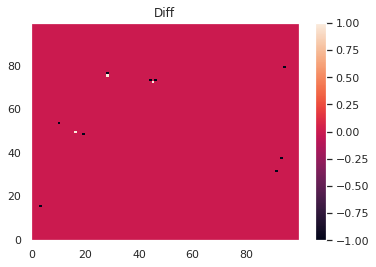

In [12]:
diff = voting_map - gt_e
plot_extended_space(diff, label="Diff")

When looking at the "Diff" graph, we can see that some of the pixels -1 and +1 are really close, yet don't cancel each other out. This is a problem since the distance which they are from one another will not affect the calculated error. Our error function is Hamming-like, it's all or nothing. We wont learn very well from this kind of error functions. Optimal Transport Distance would be much better in this case.